In [110]:
# Load Packages needed for report
#standard packages
import pandas as pd 
import numpy as np
import random
import math

#plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

#modeling packages (including data splitting packages)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# Used for Confusion Matrix
from sklearn import metrics

# Introduction 

Our objective for the mini project was to find a data set we both enjoyed, and to build models to either maximize classification accuracy or minimize MSE of a quantitative variable. We selected UFC fight data, which included data of over 4,000 official UFC fights, to predict the winner of each fight. The original CSV and data information can be found at this link: (https://www.kaggle.com/mdabbert/ultimate-ufc-dataset). The full file contains 4,292 observations and 113 columns. 

In [4]:
# Reading data 
data = pd.read_csv("ufc-master.csv")
data.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,...,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs
0,Deiveson Figueiredo,Joseph Benavidez,-225,180,44.444444,180.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,2.0,NaN,Red,SUB,Rear Naked Choke,1.0,4:48,288.0
1,Jack Hermansson,Kelvin Gastelum,-112,-112,89.285714,89.285714,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,Red,SUB,Heel Hook,1.0,1:18,78.0
2,Marc Diakiese,Rafael Fiziev,-167,135,59.880240,135.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Blue,...,NaN,NaN,NaN,NaN,neither,U-DEC,NaN,3.0,5:00,900.0
3,Ariane Lipski,Luana Carolina,-125,100,80.000000,100.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Red,...,NaN,NaN,NaN,NaN,neither,SUB,Kneebar,1.0,1:28,88.0
4,Alexandre Pantoja,Askar Askarov,-210,165,47.619048,165.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,Blue,...,NaN,NaN,NaN,NaN,neither,U-DEC,NaN,3.0,5:00,900.0


In [5]:
data.shape

(4292, 113)

In [7]:
#Checking for missing data
NAs = pd.concat([data.isnull().sum()], axis=1, keys=["Train"])
NAs[NAs.sum(axis=1) > 0]

,Train
B_avg_SIG_STR_landed,930
B_avg_SIG_STR_pct,765
B_avg_SUB_ATT,832
B_avg_TD_landed,833
B_avg_TD_pct,842
R_avg_SIG_STR_landed,455
R_avg_SIG_STR_pct,357
R_avg_SUB_ATT,357
R_avg_TD_landed,357
R_avg_TD_pct,367


# Data Cleaning

Before going very far into visualizations, we decided to clean our data of NA's. Luckily for us, NA's were mostly grouped by redundant columns, not by random rows, so in the end, **we were able to eliminate all NA's and only lose 1 row!**

For simplicity sake, we will not show all the of the cleaning code, and instead just import a new CSV file from here on out. However, here is a quick description of some of the columns we did remove, and why. 

### 1. Rank Columns

As you can see directly above, the original data frame contains 4292 observations with 113 rows, but many of the columns are filled with Na's, specifically the rank columns. This is because if the Blue figther is ranked third overall among heavyweights, then his rank will be NA for every other weight class. Since the better_rank column combines all the information of fighter rank and returns a simple categorical variable of which fighter has the better rank, we decided to eliminate all rank columns and stick with the simpler and more efficient better_rank predictor. 


### 2. Fight Finish Details

While in the future exploring finish time and type details would be interesting, it is inadvisable to impute the mean or mode fight finish type, because there are so many missing values for that column (over 2000), and because finish details are something any UFC fan knows are extremely important to get correct. Finish times are slightly less important, and with few missing values, we should have imputed the mean or mode finish times and finish rounds, but given this is a mini project, we decided to skip that work for likely insignificant predictors. 


### 3. Strikes Landed Data

This the data more associated with fight winner that I especially wish we had taken the time to impute. Now that I am more comfortable with Python, I definitely could have for several of the variables, however given time constrains, we decided to pass on this option. Our biggest concern was that unequal amounts of data are missing for Red versus Blue fighters, resulting in approximately twice as much data being imputed for the Blue fighters as for the Red. This may or may not have been a serious issue for our models, but it was curious enough that we decided to leave it out for this project.


#### Side Note:

One data point was change on top of this, a reach_dif observation that had been incorrectly calculated. The correct value was inserted. The code that we used to drop NA columns is below:
```
ufc_cut = pd.DataFrame.dropna(ufc_master, axis = 1, how = "any") 
ufc_cut.shape 
ufc_cut.columns 

```

In [11]:
#Here is the new, official data 
ufc_official = pd.read_csv("ufc_offical2 2.csv")
y = ufc_official.Winner #label
x = ufc_official.drop('Winner', axis = 1) #features


In [10]:
ufc_official.head()

,Unnamed: 0,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,...,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,empty_arena,constant_1,better_rank
0,0,Deiveson Figueiredo,Joseph Benavidez,-225,180,44.444444,180.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,...,3,-2.54,-7.62,3,0.99,-1.8,-0.31,1,1,Red
1,1,Jack Hermansson,Kelvin Gastelum,-112,-112,89.285714,89.285714,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,...,0,-10.16,-15.24,-4,-1.38,-0.6,-1.43,1,1,Red
2,2,Marc Diakiese,Rafael Fiziev,-167,135,59.880240,135.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,...,0,-5.08,-5.08,0,1.22,0.0,-1.59,1,1,neither
3,3,Ariane Lipski,Luana Carolina,-125,100,80.000000,100.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,...,0,0.00,5.08,1,3.15,1.7,-0.33,1,1,neither
4,4,Alexandre Pantoja,Askar Askarov,-210,165,47.619048,165.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,...,-2,2.54,0.00,-3,-1.15,-1.3,0.90,1,1,neither


In [19]:
# Creating Target variable column
ufc_official["Target"] = np.where(ufc_official["Winner"].str.contains("Red"), 1, 0)

In [21]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = ufc_official.corr()

<Figure size 864x720 with 0 Axes>

In [8]:
#Correlation with output variable
cor_target = abs(cor["Target"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

R_odds     0.333623
B_odds     0.337662
R_ev       0.313217
B_ev       0.312062
R_age      0.107537
B_age      0.105494
age_dif    0.157110
Target     1.000000
Name: Target, dtype: float64

The above shows which columns have the strongest correlation the the Target Column

#  Data Visualization

### Plot 1

Text(0.5, 1.0, 'Winner Count by Fighter')

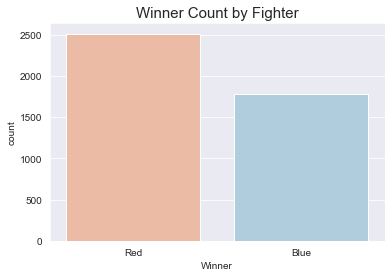

In [69]:
plot1 = sns.countplot('Winner', data = ufc_official,
              palette="RdBu")
plot1.set_title("Winner Count by Fighter", fontsize = 15)

In [68]:
ufc_official['Winner'].value_counts() / len(ufc_official['Winner'])

Red     0.584945
Blue    0.415055
Name: Winner, dtype: float64

Our first plot is the first plot any data scientist should make when working with a classification problem. We can clearly see that the R Fighters win more often than the Blue Fighter, and when one calculates the frequencies of winners using the entire data set, we see that the Red Fighter wins 58% of the time. Therefore, our model must be more than 58% accurate, otherwise we are better of always picking the Red Fighter to win. 

### Plot 2

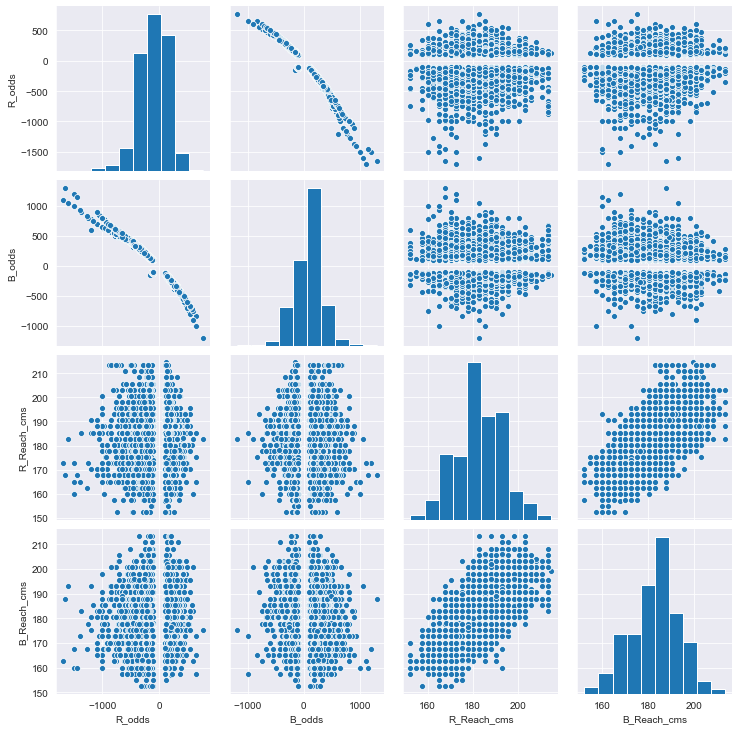

In [56]:
sns.set_style("darkgrid")
plot2 = sns.pairplot(ufc_official[['R_odds', 'B_odds', 'R_Reach_cms', 'B_Reach_cms']])

From the pairplot above, we can see that generally, Red Fighters were favorted to win over Blue Fighters (remember that when a Red Fighter's odds are -10, they are favored to win, and -100, they are even more favored, and so on). However, it does not appear that an increase in a fighter's reach is correlated with an increase in odds. Finally, when comparing Red Fighter's reach versus Blue Fighter's reach, they are generally very similar, and thus follow a linear fit. Again, however, this is nothing truly special to report, as the UFC tries to match fighters with similar weights, and by extension similar heights and wingspans. 

### Plot 3

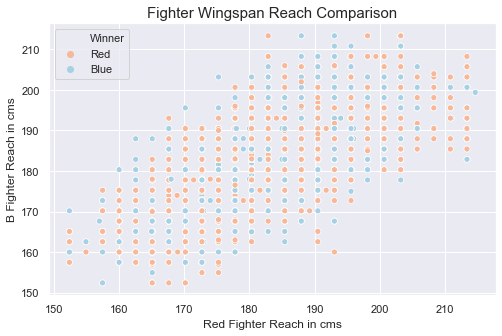

In [78]:
plot3 = sns.scatterplot(x = "R_Reach_cms", y = "B_Reach_cms", data = ufc_official, hue = "Winner",  palette="RdBu")
plot3.set(xlabel = "Red Fighter Reach in cms", ylabel = "B Fighter Reach in cms")
plot3.set_title('Fighter Wingspan Reach Comparison', fontsize = 15)
sns.set(rc={'figure.figsize':(7,4)})

Just a quick closer look into Fighter Wingspan comparison, colorized by who ended up winning the fight. Overall, there does not appear to be a particular trend - fighters with wingspan advantages tend to win slightly more than fighters with wingspan disadvantages, but barely. At this point, it does not appear that fighter reach or reach difference will be a good predictor of winner. 

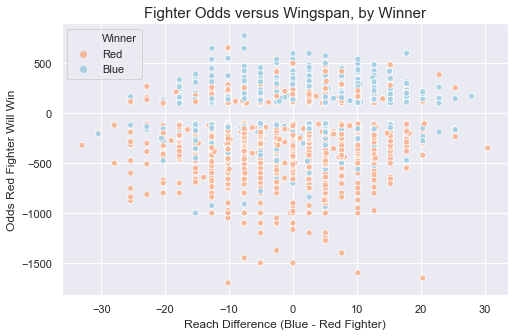

In [83]:
plot4 = sns.scatterplot(x = "reach_dif", y = "R_odds", data = ufc_official, hue = "Winner",  palette="RdBu")
plot4.set(xlabel = "Reach Difference (Blue - Red Fighter)", ylabel = "Odds Red Fighter Will Win")
plot4.set_title('Fighter Odds versus Wingspan, by Winner', fontsize = 15)
sns.set(rc={'figure.figsize':(9,5)})

Here we begin to see more of a trend. As the Red Fighter is more favored to win, they do indeed end up winning the fight more often. However, Fighter odds do not appear to be correlated at all with reach difference. 

### Plot 5

Text(0.5, 1.0, 'Distribution of Reach Difference')

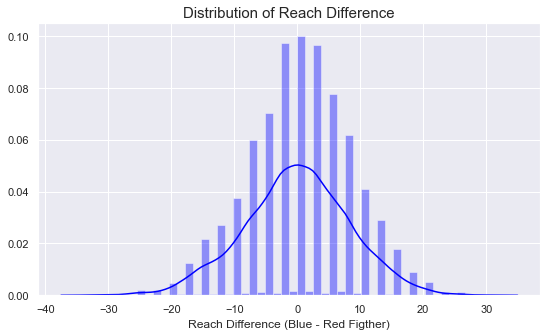

In [85]:
plot5 = sns.distplot(ufc_official['reach_dif'], color = "blue")
plot5.set(xlabel = "Reach Difference (Blue - Red Figther)")
plot5.set_title("Distribution of Reach Difference", fontsize = 15)

This plot is representative of almost all other fighter statistic data in the file - they all follow a normal distribution. This is to be expected generally regarding physical human features, including height, weight, wingspan, etc., however we hoped to at least see these distributions shift slightly when the plots are groups by fight winner, such as in Plot 6. This was not the case in any of the plots we made. In other words, no major trends in the data can be found. 

### Plot 6

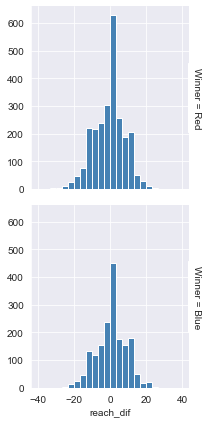

In [58]:
plot6 = sns.FacetGrid(ufc_official, row="Winner", margin_titles=True)
bins = np.linspace(start = -40, stop = 40, num = 25)
plot6.map(plt.hist, "reach_dif", color="steelblue", bins=bins)

### Plot 7

Text(0.5, 1.0, 'Bet Returns by Winner')

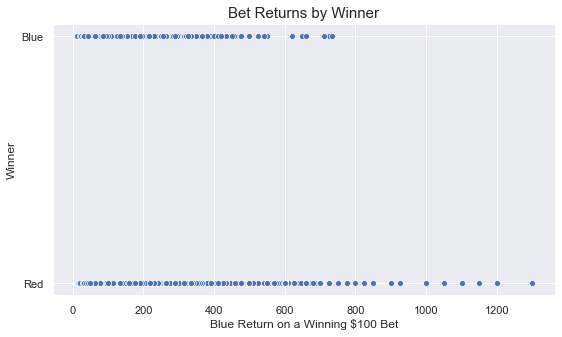

In [87]:
plot7 = sns.scatterplot(x = 'B_ev', y = "Winner", data = ufc_official)
plot7.set(xlabel = "Blue Return on a Winning $100 Bet")
plot7.set_title("Bet Returns by Winner", fontsize = 15)

The *only* significant trends in the data we could find had to do with fighter odds and money returns on bets. All four of these statistics are calculated by Las Vegas bookies, so they have a vested interest in being as accurate as possible. As such, B_ev, R_ev, B_odds, and R_odds are the four most significant predictors of all the predictors. Above, as we can see, Red fighters are more likely to win as the return on a winning $100 bet for the Blue fighter increases. In other words, as the odds the Red Fighter will win, the more likely the Red fighter *will* indeed win. 

The same conclusion can be see in plot 8 below, that as the odds improve for a particular fighter, the more likely they are to win. 

### Plot 8 

Text(0.5, 1.0, 'R Odds by Winner')

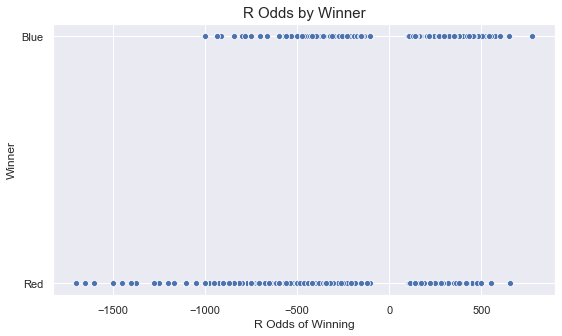

In [88]:
plot8 = sns.scatterplot(x = 'R_odds', y = "Winner", data = ufc_official)
plot8.set(xlabel = "R Odds of Winning")
plot8.set_title("R Odds by Winner", fontsize = 15)

# Modelling
We are implementing both Logistic Regression and Random Forest models to make a predictions on the UFC data set.

## Model Selection

#### Logistic Regression
Logistic regression is commonly used machine learning algorithm because it's highly interpretable, doesn't require too much computational power and doesn't need its input features to be scaled. Another advantage is that logistic regression is a classification model which outputs probabilities. This is an advantage because you can compare the outputs of two instances and determine which one is predicted to be closer to your target class. One thing to look out for when implementing logistic regression is that it cannot solve non-linear problems.

#### Random Forest
Random forest is a supervised learning algorithm that randomly creates and merges multiple decision trees into one “forest.” The goal is not to rely on a single learning model, but rather a collection of decision models to improve accuracy. The primary difference between this approach and the standard decision tree algorithms is that the root nodes feature splitting nodes are generated randomly.

## Logistic Regression

In [25]:
# Creating Target variable column
ufc_official["Target"] = np.where(ufc_official["Winner"].str.contains("Red"), 1, 0)

In [28]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = ufc_official.corr()
#Correlation with output variable
cor_target = abs(cor["Target"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

R_odds     0.333623
B_odds     0.337662
R_ev       0.313217
B_ev       0.312062
R_age      0.107537
B_age      0.105494
age_dif    0.157110
Target     1.000000
Name: Target, dtype: float64

<Figure size 864x720 with 0 Axes>

In [29]:
# Create Classifiers
lr = LogisticRegression()

In [30]:
# Our 2 X columns 
ufc_cut_feat = ufc_official[['R_odds', 'age_dif']]

# Our Y column
ufc_cut_targ = ufc_official['Winner']

In [31]:
# Creating Training and Test set
seed = 50  # so that the result is reproducible
x_train, x_test, y_train, y_test = train_test_split(ufc_cut_feat, ufc_cut_targ , test_size = 0.2, random_state = seed)

In [32]:
# Fitting our Logistic Regression Model
lr.fit(x_train, y_train)

LogisticRegression()

In [33]:
# Make predictions on test data
predictions = lr.predict(x_test)

In [34]:
# Use score method to get accuracy of model
score = lr.score(x_test, y_test)
print(score)

0.6623981373690337


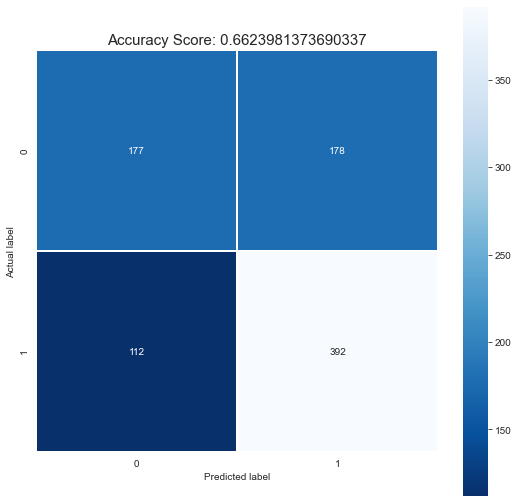

In [35]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Random Forest

In [ ]:
#First, lets drop the Target column and also split the data into feature and label
ufc_official = ufc_official.drop("Target", axis = 1)

In [113]:
y = ufc_official.Winner #label
x = ufc_official.drop('Winner', axis = 1) #features

#drop categorical variables that will be impossible to get dummies for
x = x.drop(['R_fighter', "B_fighter", "location", "country", "date", "weight_class"], axis = 1)

#get dummy variables
x = pd.get_dummies(x, columns = ["title_bout", "gender", "better_rank", "B_Stance", "R_Stance"], drop_first=True)
y = pd.get_dummies(y, columns = 'Winner', drop_first = True)

#split into training and testing, and then scale it
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.3, random_state = 3544)
scaler = StandardScaler()
x_train1 = scaler.fit_transform(x_train1)
x_test1 = scaler.transform(x_test1)

In [97]:
#For loop to determine the ideal number of trees (note that we are still using all 70 predictors)
n_estimators = [1,2,4,20,50,100, 200, 500, 1000, 1500]
train_results = []
test_results = []
for estimator in n_estimators:
    rf_trees = RandomForestClassifier(n_estimators=estimator, n_jobs = -1)
    rf_trees.fit(x_train1, y_train1.values.ravel())
    
    train_pred = rf_trees.predict(x_train1)
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_train1, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rf_trees.predict(x_test1)
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test1, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

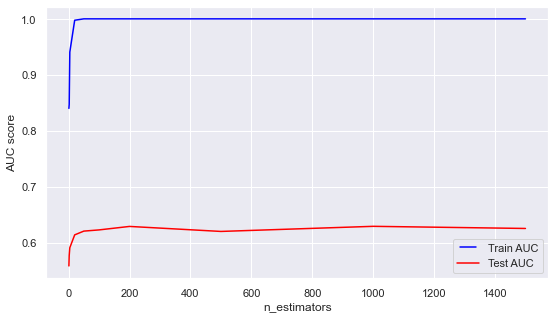

In [100]:
#Plot AUC versus number of trees
line1, = plt.plot(n_estimators, train_results, color = 'blue', label = 'Train AUC')
line2, = plt.plot(n_estimators, test_results, color = 'red', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show() 

In [104]:
#now let's create a for loop to find the ideal max depth
max_depth = np.linspace(1,32,32, endpoint = True)
train_results = []
test_results = []
for depths in max_depth:
    rf_trees = RandomForestClassifier(max_depth = depths, n_jobs = 42, n_estimators=1000)
    rf_trees.fit(x_train1, y_train1.values.ravel())
    
    train_pred = rf_trees.predict(x_train1)
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_train1, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = rf_trees.predict(x_test1)
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test1, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

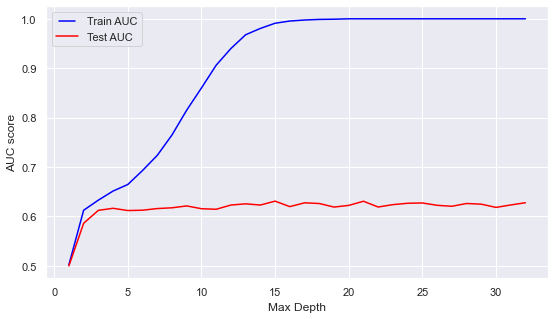

In [105]:
line1, = plt.plot(max_depth, train_results, color = 'blue', label = 'Train AUC')
line2, = plt.plot(max_depth, test_results, color = 'red', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Max Depth")
plt.show()
#Seems like 5 is a sufficient max depth, but I will use 14 just to be sure

In [106]:
#Now lets run feature selection to narrow down to the best predictors
rfecv = RFECV(estimator = RandomForestClassifier(), cv = 5, step = 1)
rfecv = rfecv.fit(x_train1, y_train1.values.ravel())
g  = rfecv.get_support(1)
len(g)

#ignore the below comments. This was my tinkering

#that actually didn't work as well as hoped. the next best thing is to take a random forest model from about and 
#check the importances of each. Variance important plots are show below, but know these are approximately the best predictors
#good_preds = np.array([0,1,2,4,28,40,47,53,54,55,56])

In [152]:
#resplit x_train and y_train because they are currently defined incorrectly thanks to the plots above. 
#We will keep the same seed
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.3, random_state = 3544)
scaler = StandardScaler()
x_train1 = scaler.fit_transform(x_train1)
x_test1 = scaler.transform(x_test1)

#subset x_train1 by the good predictors
x_train1 = pd.DataFrame(x_train1)
x_train1 = x_train1[x_train1.columns[g]]
#create another object of class random forest classifier, this time with more trees
#also i'll change the max_depth, and the max_features (which is like mtry in R)
rf = RandomForestClassifier(n_estimators = 1000, random_state = 3544, n_jobs = 42, max_depth = 3, max_features=int(math.sqrt(len(g))))
rf.fit(x_train1, y_train1.values.ravel())
#predict the y_train1 labels to get the training error
y_train_pred1 = rf.predict(x_train1)
print('training set accuracy %2.2f' % (accuracy_score(y_train1, y_train_pred1)*100))
print("training set f1 %2.2f" % (f1_score(y_train1, y_train_pred1)*100))
#Do the same thing but for testing error
x_test1 = pd.DataFrame(x_test1)
x_test1 = x_test1[x_test1.columns[g]]
#predict the y_test1 labels to get the testing error
y_test_predict1 = rf.predict(x_test1)
print('testing set accuracy %2.2f' % (accuracy_score(y_test1, y_test_predict1)*100))
print("testing set f1 %2.2f" % (f1_score(y_test1, y_test_predict1)*100))


#let's check the AUC score, to get another metric that we are doing the right thing
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test1, y_test_predict1)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('ROC AUC score = %2.2f' % (roc_auc*100) + '%')

training set accuracy 67.37
training set f1 75.67
testing set accuracy 64.13
testing set f1 72.34
ROC AUC score = 61.22%


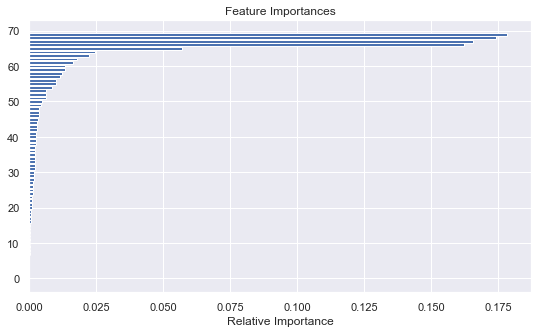

In [155]:
#this is a plot to show feature importance
#features=x.columns[g]
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices), features['indices']))
plt.xlabel('Relative Importance')
plt.show()

Although I was unable to label the y axis with predictor names, if one prints out the importances of each predictor and matches it to the column names, R_odds, B_odds, B_ev, and R_ev are by far the most important predictors. 

In [146]:
rf_score = rf.score(x_test1, y_test1)

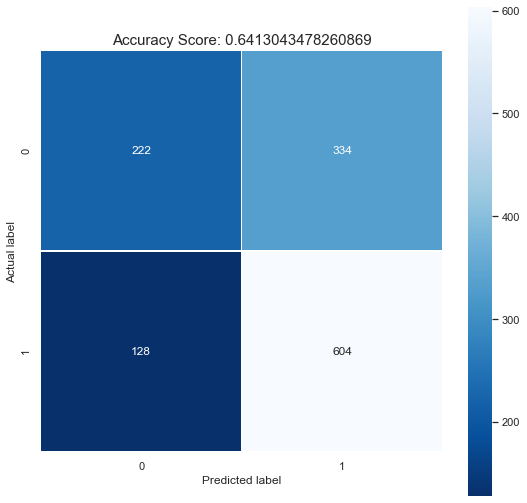

In [147]:
cm = metrics.confusion_matrix(y_test1, y_test_predict1)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(rf_score)
plt.title(all_sample_title, size = 15);

## Model Results
The three accuracy metrics we will use for this binary classification problem are Accuracy, Sensitivity and Specificity. Note that AUC was also used, but only in assessing random forest classifying accuracy. 

### 1.) Accuracy (all correct / all)
###### Logistic Regression
177 + 392 = 569 <br>
177 + 392 + 178 + 112 = 869 <br>
569 / 869 = 63.79% <br>

###### Random Forest
222 + 604 = 826 <br>
222 + 334 + 128 + 604 = 1,288 <br>
826 / 1,288 = 64.13% <br>


### 2.) Sensitivity (true positives / all actual positives)
###### Logistic Regression
177 / (177 + 178) = 49.85%

###### Random Forest
222 / (222 + 334) = 39.92%

### 3.) Specificity (true negatives / all actual negatives)
###### Logistic Regression
392 / (392 + 112) = 77.77%

###### Random Forest

604 / (604 + 128) = 82.51%


# Results Discussion

In regards to Accuracy you can see that logistic regressin performed better. While random forest performed better in regards to specificity, logistic regression performed better in sensitivity. Overall, we recommend the logistic regression model for this predicting who will win a UFC fight. It is more accurate than always 

In the future, we would like to run more Random Forest tests, and get to the bottom of why Aidan's random forest practice on Spyder got to 87% accuracy, but he was never able to reproduce those results on Juypter Notebook. 